In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization # model creation hyperparamters for cnn needed
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError # for performance measurement
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive

# Data Preparation

Data Loading

In [4]:
!cp -r /content/drive/MyDrive/xray_dataset_covid19/ /content/xray_dataset_covid19/

In [5]:
dataset_path = "/content/xray_dataset_covid19"

# loading Entire dataset for splitting training and validation
t_v_dataset = image_dataset_from_directory(dataset_path + '/train',
                                           image_size = (224, 224),
                                           batch_size = 32,
                                           shuffle = True,
                                           seed = 42)


Found 148 files belonging to 2 classes.


In [21]:
class_names = t_v_dataset.class_names
t_v_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
for data in t_v_dataset.take(1):
  for inner_data in data:
    print(inner_data)

tf.Tensor(
[[[[4.77166672e+01 4.77166672e+01 4.77166672e+01]
   [4.88651733e+01 4.88651733e+01 4.88651733e+01]
   [4.83601227e+01 4.83601227e+01 4.83601227e+01]
   ...
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]]

  [[5.22254486e+01 5.22254486e+01 5.22254486e+01]
   [5.40000000e+01 5.40000000e+01 5.40000000e+01]
   [5.48236542e+01 5.48236542e+01 5.48236542e+01]
   ...
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]]

  [[5.70319977e+01 5.70319977e+01 5.70319977e+01]
   [5.59888306e+01 5.59888306e+01 5.59888306e+01]
   [5.57819786e+01 5.57819786e+01 5.57819786e+01]
   ...
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.95759010e+00 2.95759010e+00 2.95759010e+00]
   [2.04240990e+00 2.04240990e+00 2.04240990e+00]]

  ...

  [[1.12744034e+02 1.12744034e+02 1.12744034e+02]
   [1

In [45]:
# lets split into val_dataset and training_dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO):
  DATASET_SIZE = len(t_v_dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  print(len(list(train_dataset.as_numpy_iterator())))

  val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  print(len(list(val_dataset.as_numpy_iterator())))

  return train_dataset, val_dataset

In [46]:
TRAIN_RATIO = 0.9
VAL_RATIO = 0.1
train_dataset, val_dataset = splits(t_v_dataset, TRAIN_RATIO, VAL_RATIO)

4
1


In [115]:
test_dataset = image_dataset_from_directory(
    dataset_path + '/test',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True
)
test_dataset
test_class_names = test_dataset.class_names
test_class_names

Found 40 files belonging to 2 classes.


['NORMAL', 'PNEUMONIA']

# Dataset Visualization

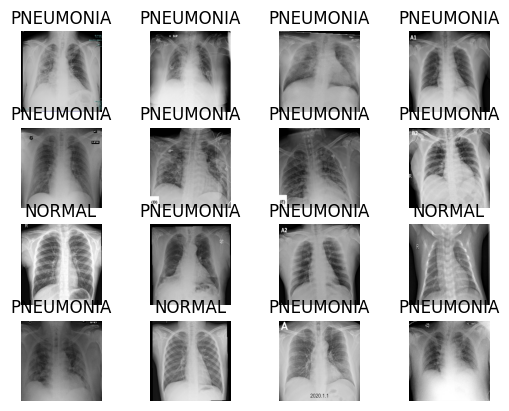

In [47]:
for images, labels in train_dataset.take(1):
    for i in range(len(images)):
        ax = plt.subplot(4, 4, (i + 1))
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        ax.axis('off')  # Turn off axis
        if i == 15:  # Break loop after 16 subplots
            break

In [54]:
class_names

['NORMAL', 'PNEUMONIA']

# Model Creation

In [64]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides=(1,1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),

    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides=(1,1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),


    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),

    Dense(1, activation = 'sigmoid')



])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_17 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 6)       330       
                                                                 
 batch_normalization_18 (Bat  (None, 109, 109, 6)      24        
 chNormalization)                                                
                                                      

In [66]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

# Training and Optimization

In [67]:
history = model.fit(train_dataset, validation_data= val_dataset, epochs=20, verbose = 1)

Epoch 1/20
4/4 [==============================] - 16s 2s/step - loss: 0.4205 - accuracy: 0.7578 - val_loss: 1.1210 - val_accuracy: 0.9000
Epoch 2/20
4/4 [==============================] - 14s 4s/step - loss: 0.0918 - accuracy: 0.9844 - val_loss: 13.1874 - val_accuracy: 0.7000
Epoch 3/20
4/4 [==============================] - 20s 5s/step - loss: 0.0521 - accuracy: 0.9922 - val_loss: 18.4053 - val_accuracy: 0.6000
Epoch 4/20
4/4 [==============================] - 16s 4s/step - loss: 0.0626 - accuracy: 0.9688 - val_loss: 28.0664 - val_accuracy: 0.4500
Epoch 5/20
4/4 [==============================] - 18s 4s/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 8.6699 - val_accuracy: 0.8000
Epoch 6/20
4/4 [==============================] - 24s 5s/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 34.0705 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 19s 3s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 15.7304 - val_accuracy: 0.6500
Epoch 8/20
4/4 [=============

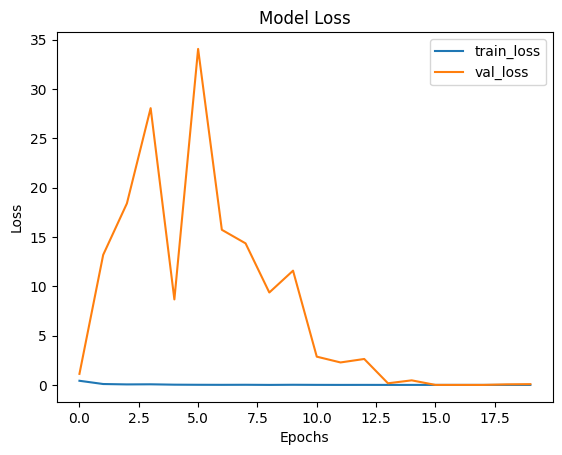

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

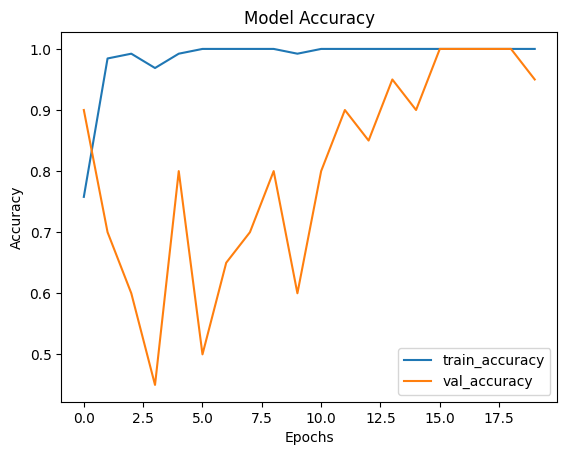

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Testing and Prediction

In [73]:
model.evaluate(test_dataset)

2/2 [==============================] - 1s 117ms/step - loss: 7.1087e-04 - accuracy: 1.0000


[0.000710872991476208, 1.0]

In [111]:
def affected_or_not(x):
  if (x < 0.6):
    return str('N')
  else:
    return str('P')

In [93]:
# affected_or_not(model.predict(test_dataset.take(1)[0]))
for images, labels in test_dataset.take(1):
  image = images[0]
  affected_or_not(model.predict(tf.expand_dims(image, axis=0)))
  break

1/1 [==============================] - 0s 63ms/step


1
1/1 [==============================] - 0s 44ms/step
1
1/1 [==============================] - 0s 43ms/step
1
1/1 [==============================] - 0s 37ms/step
0
1/1 [==============================] - 0s 40ms/step
0
1/1 [==============================] - 0s 41ms/step
1
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 40ms/step
0
1/1 [==============================] - 0s 44ms/step
0
1/1 [==============================] - 0s 52ms/step
1
1/1 [==============================] - 0s 49ms/step
1
1/1 [==============================] - 0s 56ms/step
0
1/1 [==============================] - 0s 42ms/step
0
1/1 [==============================] - 0s 55ms/step
0
1/1 [==============================] - 0s 53ms/step
1
1/1 [==============================] - 0s 43ms/step
0
1/1 [==============================] - 0s 44ms/step


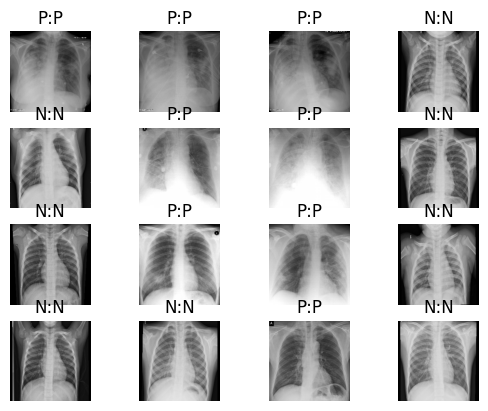

In [117]:
for images, labels in test_dataset.take(1):
    for i in range(len(images)):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = labels[i].numpy()
        print(true_label)
        predicted_label = model.predict(tf.expand_dims(images[i], axis=0))[0][0]

        plt.title(str(affected_or_not(true_label)) + ":" + str(affected_or_not(predicted_label)))
        ax.axis('off')
        if i == 15:  # Break loop after 16 subplots
            break


In [118]:
# very Small dataset but not bad for first try
# needs way more training with way larger dataset